In [83]:
from keras.models import model_from_json, Model
import keras.backend as K

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import gridspec

from sklearn.metrics import explained_variance_score
from sklearn.utils.multiclass import unique_labels
import sklearn.metrics

# 1. Setup
## 1.1 Load Model

In [2]:
MODEL_DIR = "./best_weights/2019_06_17_14_25/"
MODEL_NAME = "s1p10_model_2019_06_17_14_25"
# load json and create model
with open(MODEL_DIR + "%s.json" % MODEL_NAME, 'r') as json_file:
    loaded_model_json = json_file.read()

model = model_from_json(loaded_model_json)

# load weights into new model
model.load_weights(MODEL_DIR + "%s.h5" % MODEL_NAME)
print("Loaded model from disk")

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Loaded model from disk
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 1)  0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, 100, 100, 32) 832         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 49, 49, 32)   0           conv_0[0][0]                     
_________________________________________________________________________________________________

In [3]:
IMAGE_SHAPE = (200, 200, 1)
NUM_LABELS = 5
BINS_EDGE = np.load("./data/bins_edge.npy")
NUM_CLASSES = len(BINS_EDGE) - 1  

## 1.2 Load Validation Dataset & Get Model Prediction

In [4]:
# X_val, y_val = gen_classifier_dataset("./s1p10_data/s1p10_CH2_002_output_validation.csv", **gen_param)
X_val = np.load('./data/no_cut_CH2_validation_X.npy')
y_val_arr = np.load('./data/no_cut_CH2_validation_y.npy')
y_val = [y_val_arr[i, :, :]for i in range(NUM_LABELS)]

In [5]:
X_val.shape

(2021, 200, 200, 1)

In [6]:
y_val[0].shape

(2021, 114)

In [7]:
# Get model prediction
y_hat = model.predict(X_val, verbose=1)

2021/2021 [==============================] - 12s 6ms/step


In [8]:
y_hat[0].shape

(2021, 114)

# 2. Model Performance
## 2.1 Metrics 
Two metrics are used to access model peformance
* **Root Mean Square Error**
* **Exaplained Variance Score**

In [9]:
def one_hot_to_angle(one_hot_arr):
    """
    Decode 1 one hot encoded vector to get angle
    
    Input:
        one_hot_arr (np.ndarray): shape (1, NUM_CLASSES)
        bins_edge (np.ndarray): shape (1, NUM_CLASSES + 1)
    """
    angle_id = np.argmax(one_hot_arr)
    if angle_id < NUM_CLASSES:
        return (BINS_EDGE[angle_id] + BINS_EDGE[angle_id + 1]) / 2.
    else:
        return BINS_EDGE[angle_id]

def id_to_angle(one_hot_arr):
    """
    Decode a matrix of one_hot vector (each vector is a row)
    """
    angels = np.zeros(one_hot_arr.shape[0])
    for i in range(len(angels)):
        angels[i] = one_hot_to_angle(one_hot_arr[i, :])
    return angels

In [10]:
def root_mean_squared_error(y, y_hat):
    return np.sqrt(np.mean(np.square(y_hat - y)))

In [11]:
rmse_seq = []
eva_seq = []
for i in range(NUM_LABELS):
    # Get first angle ID in the sequence
    y_id = y_val[i]
    y_hat_id = y_hat[i]

    # Convert angle ID to angle value
    y_value = id_to_angle(y_id)
    y_hat_value = id_to_angle(y_hat_id)
    
    # calculate RMSE
    rmse_seq.append(root_mean_squared_error(y_value, y_hat_value))
    eva_seq.append(explained_variance_score(y_value, y_hat_value))

### Baseline from the paper `DroNet: Learning to Fly by Driving`:
**RMSE: 0.109**

**EVA: 0.737**

In [12]:
print("\t\t RMSE \t\t EVA")
for i in range(NUM_LABELS):
    print("Pred %d: \t %.4f \t %.4f" % (i, rmse_seq[i], eva_seq[i]))

		 RMSE 		 EVA
Pred 0: 	 0.1101 	 0.8245
Pred 1: 	 0.1159 	 0.8042
Pred 2: 	 0.1012 	 0.8491
Pred 3: 	 0.1159 	 0.8020
Pred 4: 	 0.1050 	 0.8409


## 2.2 Angle ID distribution

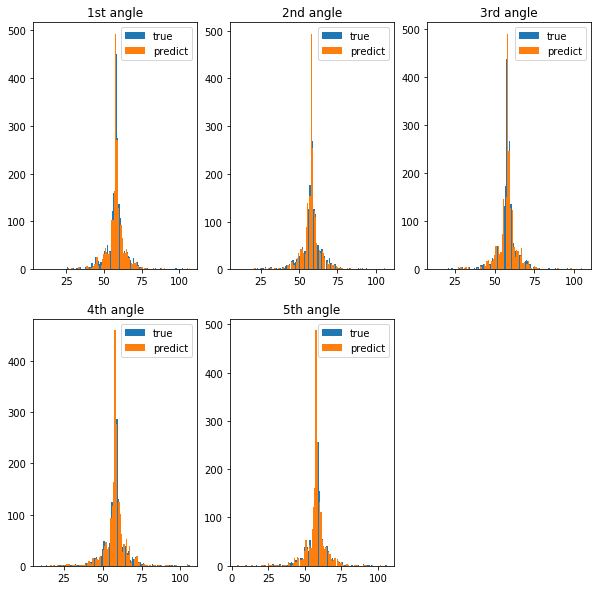

In [16]:
# convert y_val to ID
y_val_id_list = [np.argmax(y_val[j], axis=1) for j in range(NUM_LABELS)]
y_hat_id_list = [np.argmax(y_hat[j], axis=1) for j in range(NUM_LABELS)]

# Plot angel ID histogram for each prediciton in the sequence
plt.figure(figsize=(10, 10))
plt.subplot(231)
plt.hist(y_val_id_list[0], bins=NUM_CLASSES, label="true")
plt.hist(y_hat_id_list[0], bins=NUM_CLASSES, label="predict")
plt.title("1st angle")
plt.legend(loc='upper right')

plt.subplot(232)
plt.hist(y_val_id_list[1], bins=NUM_CLASSES, label="true")
plt.hist(y_hat_id_list[1], bins=NUM_CLASSES, label="predict")
plt.title("2nd angle")
plt.legend(loc='upper right')

plt.subplot(233)
plt.hist(y_val_id_list[2], bins=NUM_CLASSES, label="true")
plt.hist(y_hat_id_list[2], bins=NUM_CLASSES, label="predict")
plt.title("3rd angle")
plt.legend(loc='upper right')

plt.subplot(234)
plt.hist(y_val_id_list[3], bins=NUM_CLASSES, label="true")
plt.hist(y_hat_id_list[3], bins=NUM_CLASSES, label="predict")
plt.title("4th angle")
plt.legend(loc='upper right')

plt.subplot(235)
plt.hist(y_val_id_list[4], bins=NUM_CLASSES, label="true")
plt.hist(y_hat_id_list[4], bins=NUM_CLASSES, label="predict")
plt.title("5th angle")
plt.legend(loc='upper right')

plt.savefig("./images/predicted_angles_distribution.png")
plt.show()

# 3. Checkout layers' activation

In [17]:
# Define intermediate model to get intermediate layer output
layer_list = ['feature_map_0', 'feature_map_1', 'feature_map_2']
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=[model.get_layer(layer_name).output for layer_name in layer_list])


In [ ]:
# randomly choose 10 images from validation set to visualize layers' activation 
X_vis = X_val[np.random.randint(0, high=X_val.shape[0], size=10), ...]

# Get intermediate output with test images 
intermediate_output = intermediate_layer_model.predict(X_vis, verbose=1)

In [35]:
print("type of intermediate_output: ", type(intermediate_output))
print("len intermediate_output: ", len(intermediate_output))
print("shape of first feature map:", intermediate_output[0].shape)

type of intermediate_output:  <class 'list'>
len intermediate_output:  3
shape of first feature map: (10, 49, 49, 32)


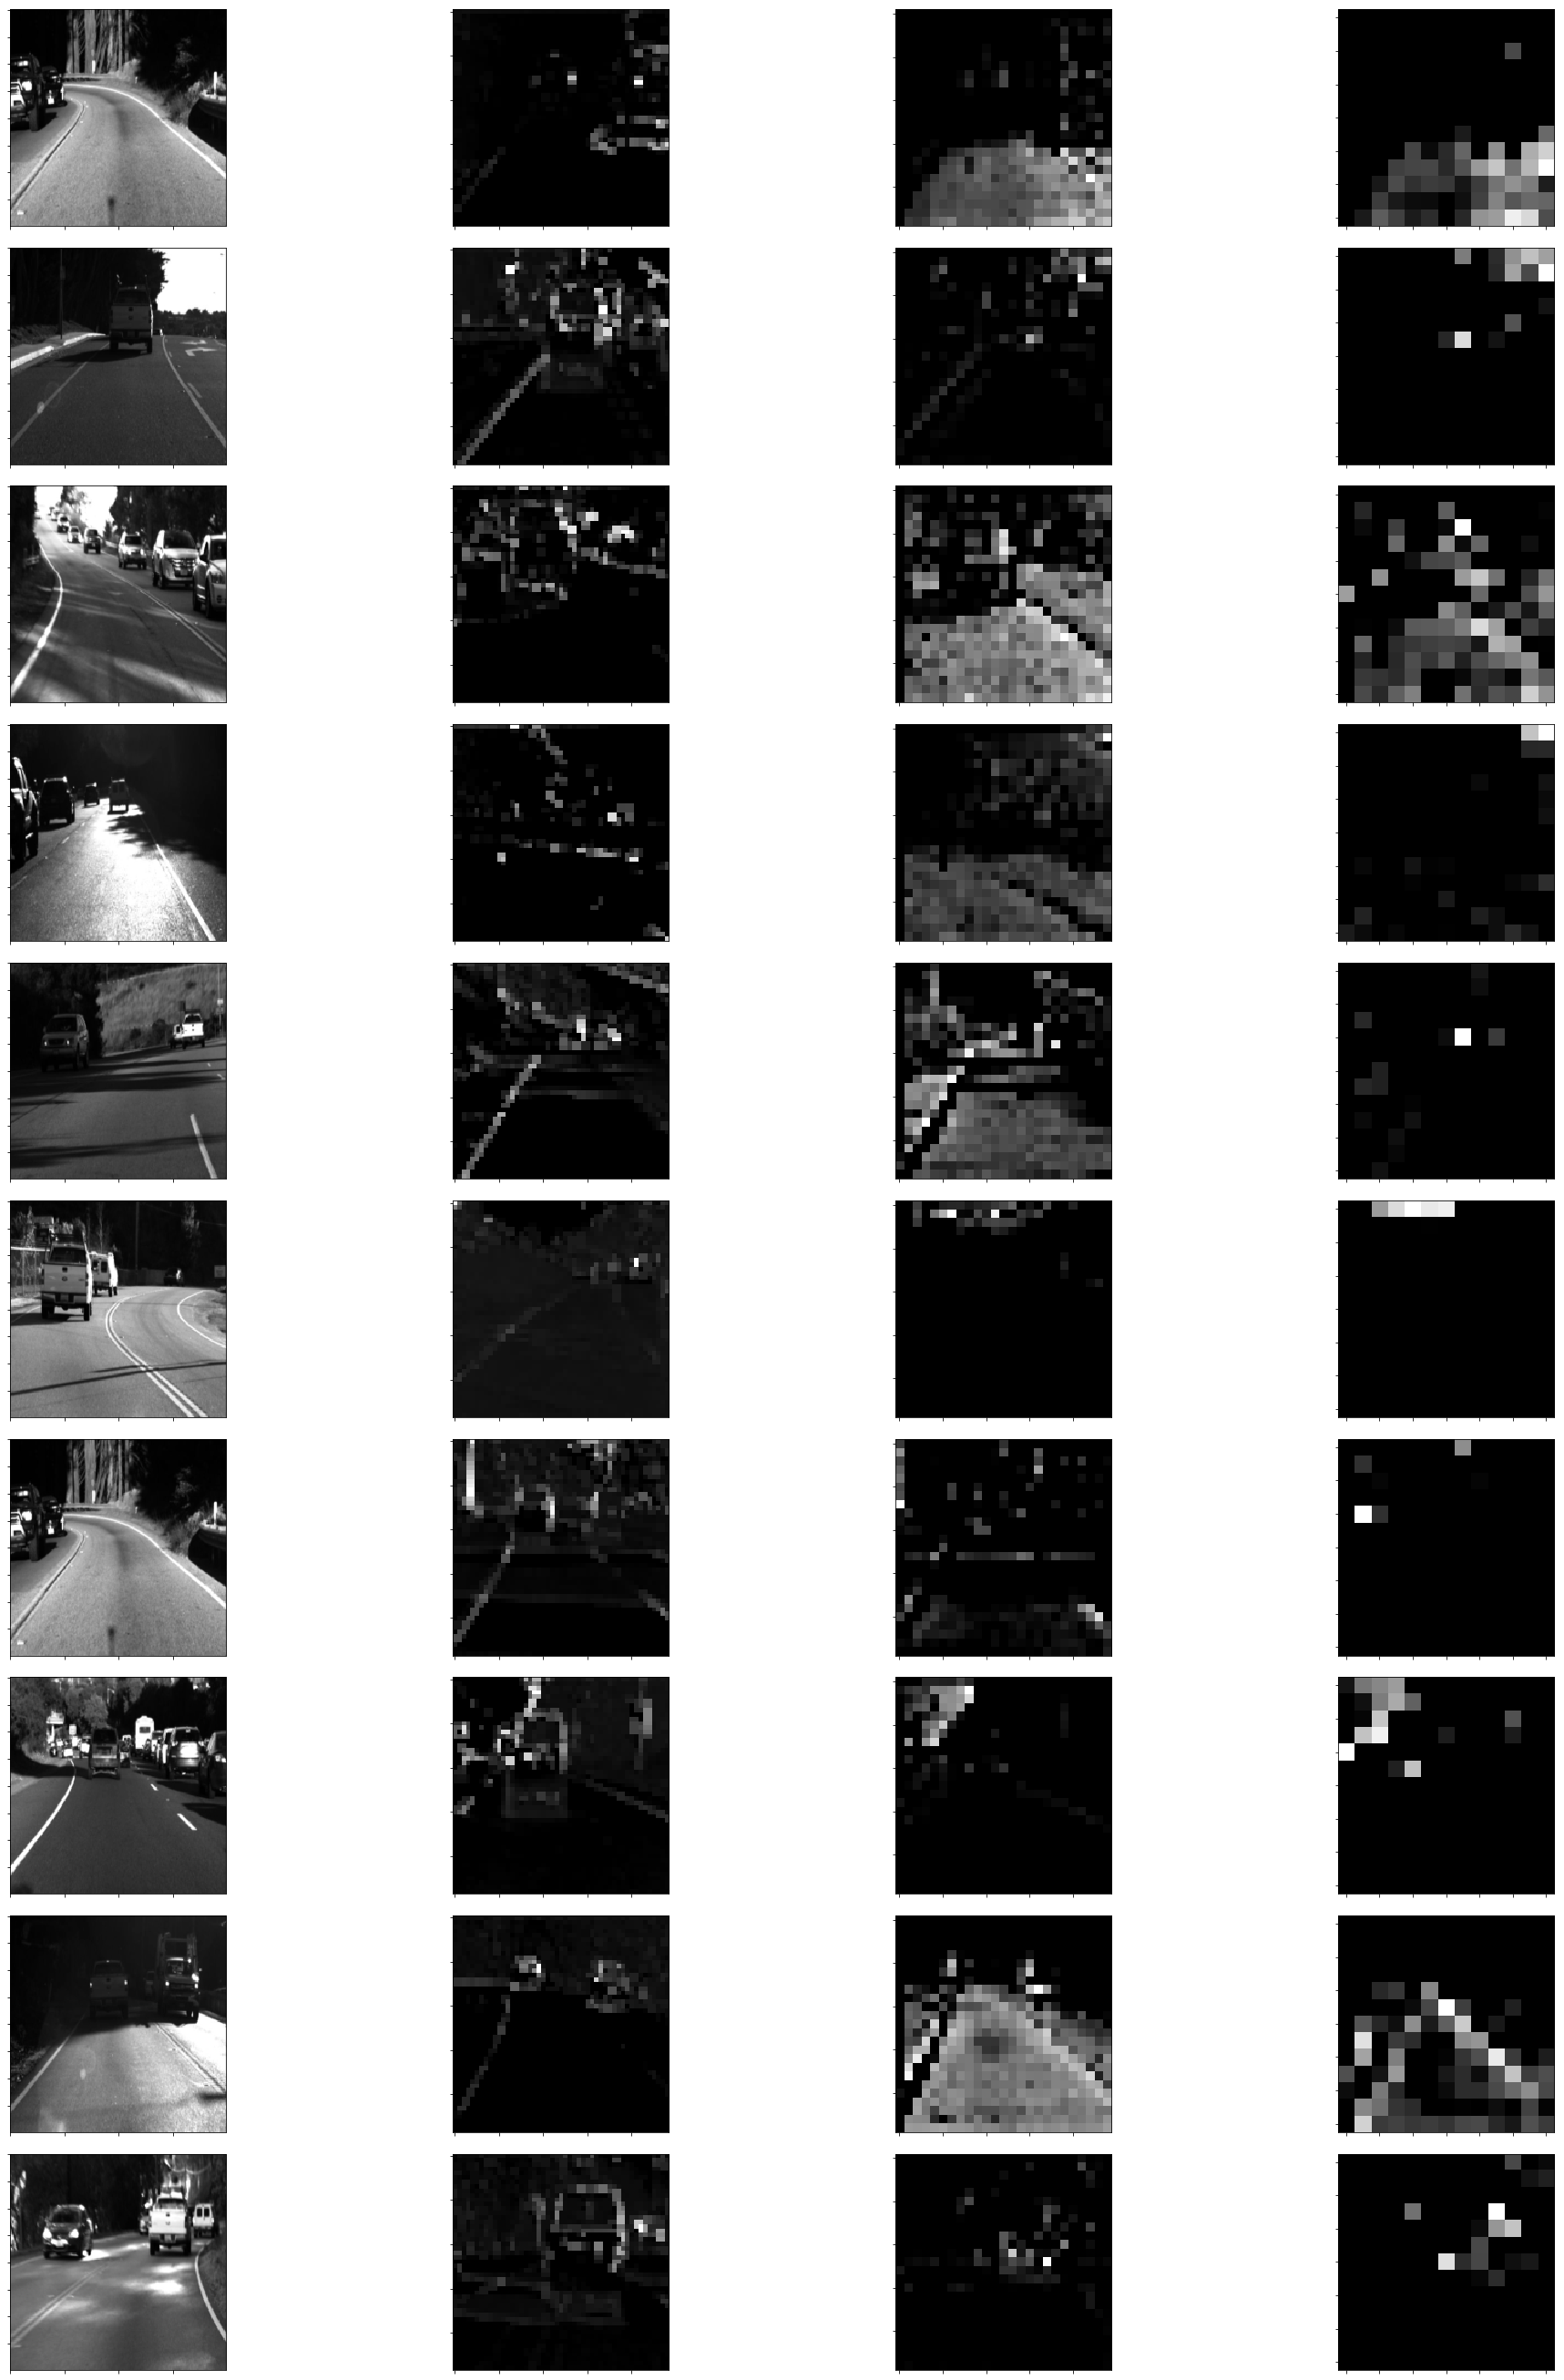

In [80]:
nrow = 10
ncol = 4

fig = plt.figure(figsize=(40, 40))

gs = gridspec.GridSpec(nrow, ncol, width_ratios=[1, 1, 1, 1],
         wspace=0., hspace=0.1, top=0.95, bottom=0.05, left=0.17, right=0.845)

for row in range(nrow):
    for col in range(ncol):
        ax= plt.subplot(gs[row, col])
        if col == 0:
            im = X_vis[row, ...].squeeze()
            ax.imshow(im, cmap='gray')
        else:
            feature_map = intermediate_output[col-1][row, ...]
            ax.imshow(feature_map[:, :, 0], cmap='gray')
        ax.set_xticklabels([])
        ax.set_yticklabels([])

plt.savefig("./images/layers_activation.png")
plt.show()

# 4. Confusion matrix

In [82]:
# Convert 1st prediction into class ID
y_val_1 = np.argmax(y_val[0], axis=1)
y_hat_1 = np.argmax(y_hat[0], axis=1)

In [88]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
    
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        norm_factor = cm.sum(axis=1)[:, np.newaxis]
        norm_factor[norm_factor == 0] = 1
        cm = cm.astype('float') / norm_factor
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=(50,50))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Normalized confusion matrix


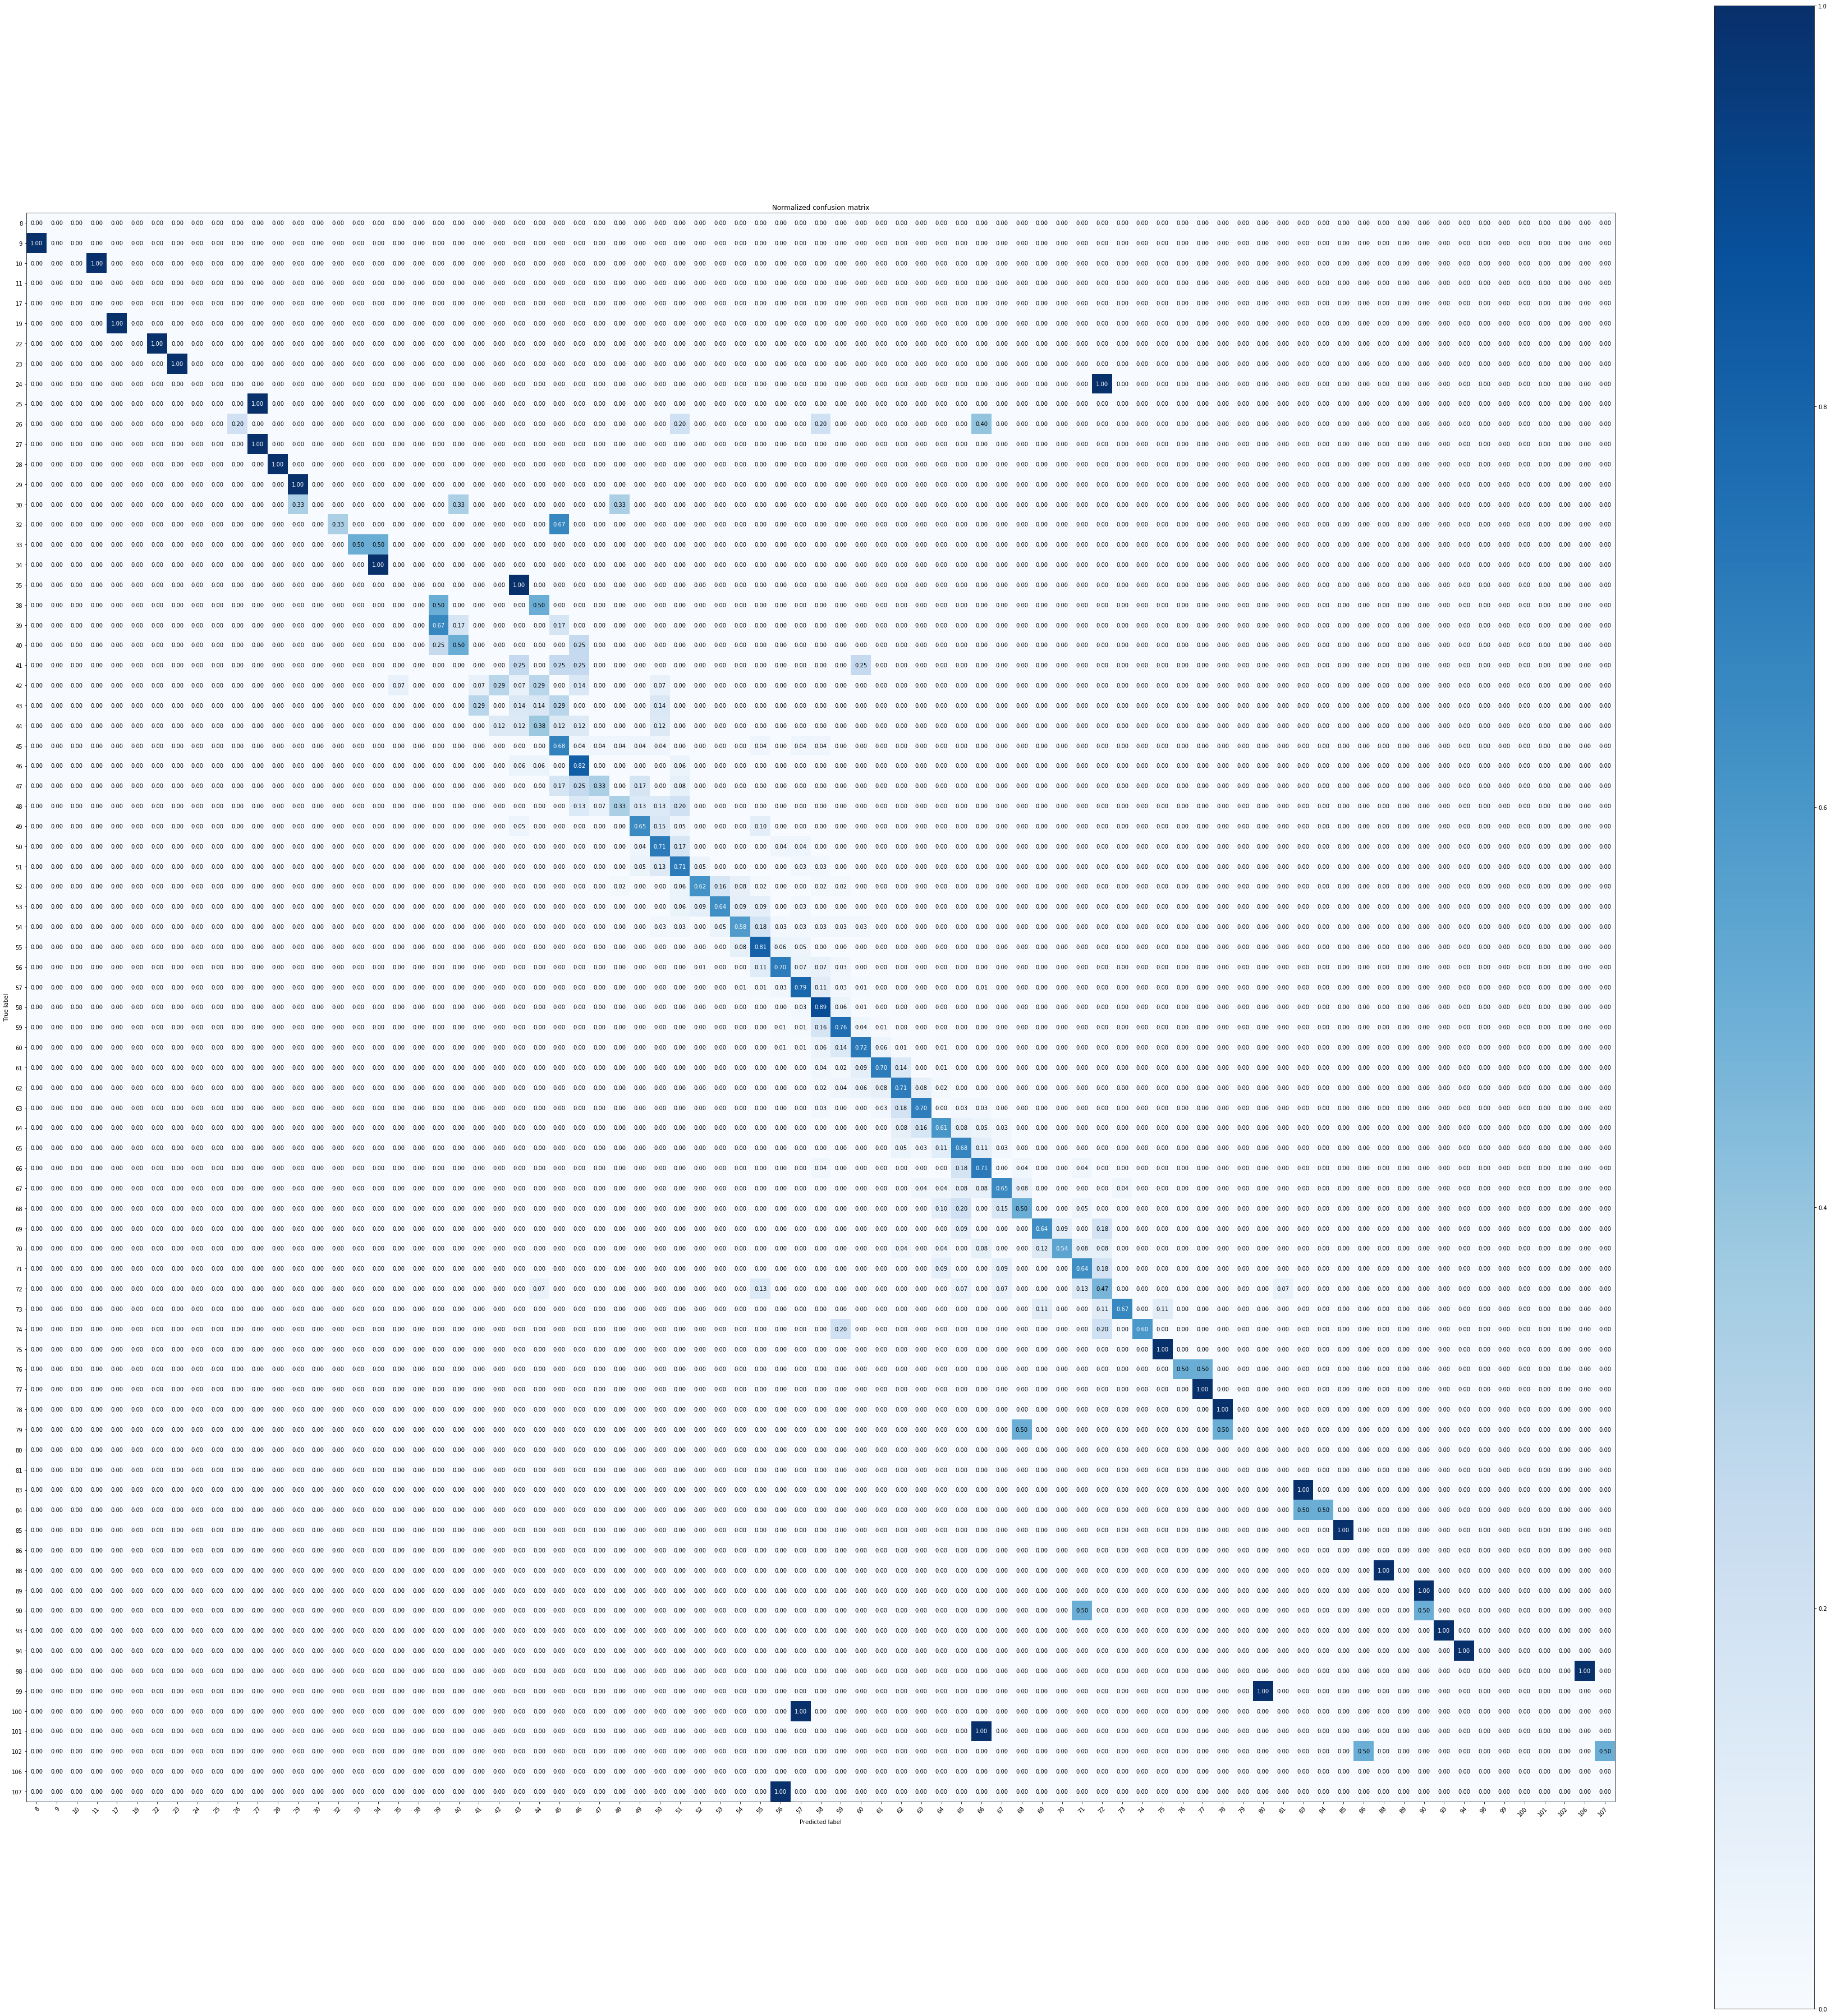

In [91]:
class_names = np.array([str(i) for i in range(114)])
plot_confusion_matrix(y_val_1, y_hat_1, class_names, normalize=True)
plt.savefig("./images/norm_confusion_matrix.png")